## Notebooks for workload prediction tests
### Using different sklearn libraries

Bytte till notebooks för de kändes lättare...

This is just for prediction tests!!

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression  

import requests

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from numpy import mean
from numpy import std
from scipy.fft import fft

### Access Target_device data

In [12]:

QuerytoolBASE = "http://127.0.0.1:5000/"
response = requests.get(QuerytoolBASE+"databaseservice",json={"autoscaler": "1998-05-02"})
data_result = response.json()


### Preprocess 

<Axes: xlabel='timestamp'>

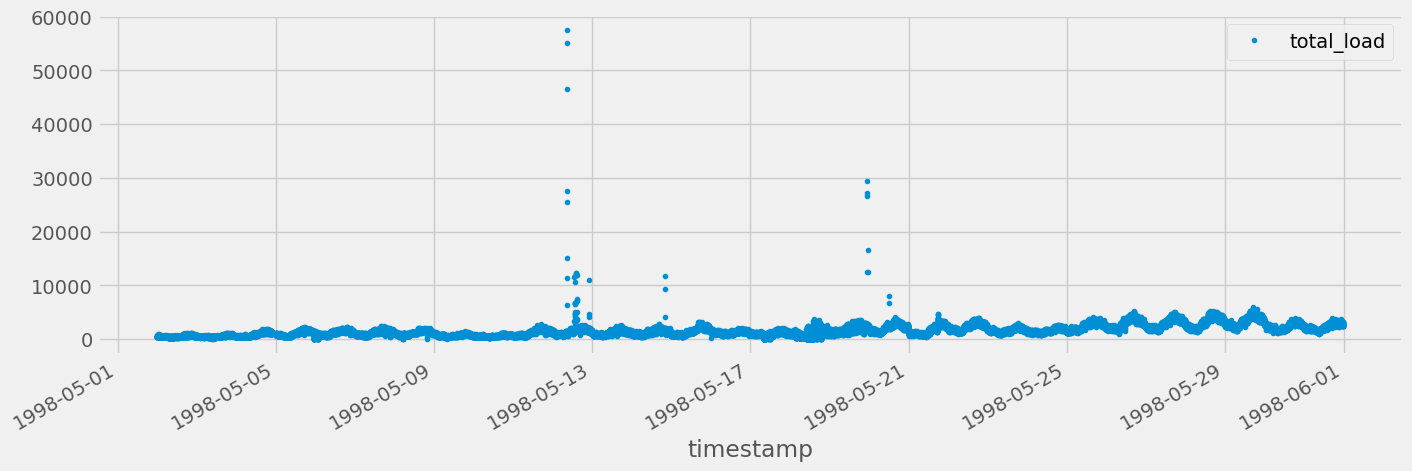

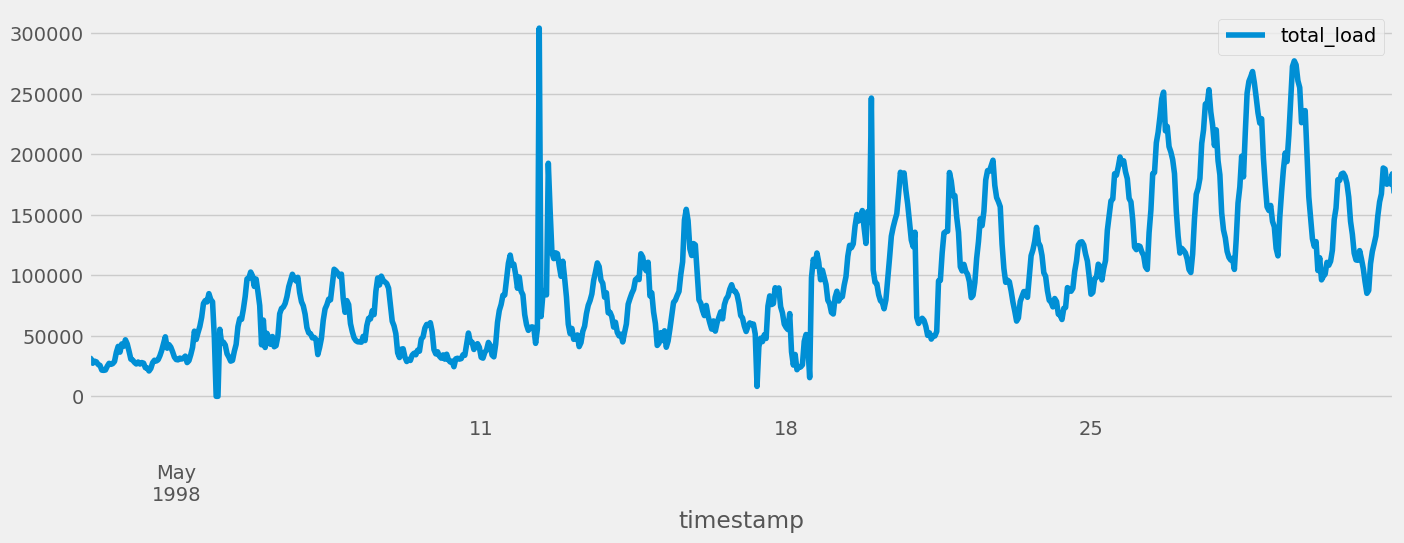

In [170]:
historical_df = pd.DataFrame(data_result, columns=['timestamp', 'average_load', 'total_load', 'instances'])
historical_df['timestamp'] = pd.to_datetime(historical_df['timestamp']) 
historical_df['total_load'] = historical_df['total_load'].astype(int)
#historical_df = historical_df[ historical_df['total_load']<6000] 
historical_df = historical_df.set_index("timestamp")
historical_df =historical_df.drop(columns=[ 'average_load', 'instances'])
historical_df.plot(style=".",figsize=(15,5))
historical_df.head()
# Resample the data per hour, round to nearest hour, and sum the total_load
hourly_sum = historical_df.resample('H').sum()
hourly_sum.plot(figsize=(15,5))

# XGBoost prediction model

### Train/ Test Split

In [173]:
#Importing libs from tutorial
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

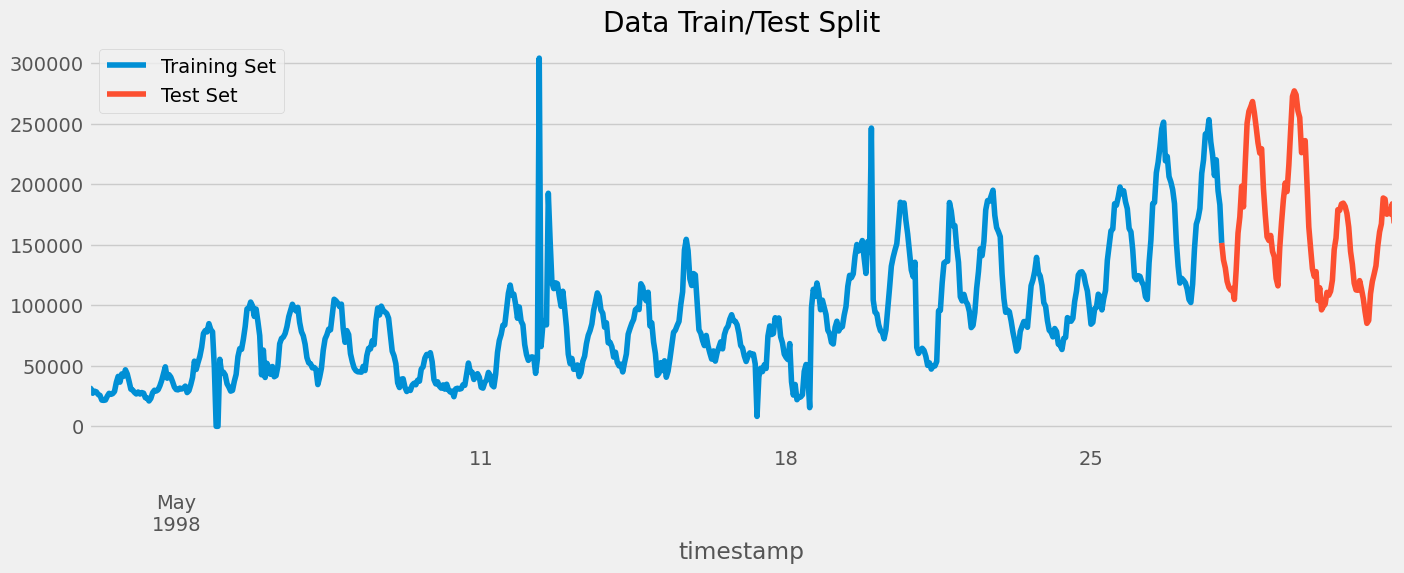

In [174]:
train = hourly_sum.loc[hourly_sum.index <= "1998-05-28 00:00:00"]
test = hourly_sum.loc[hourly_sum.index >= "1998-05-28 00:00:00"]
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

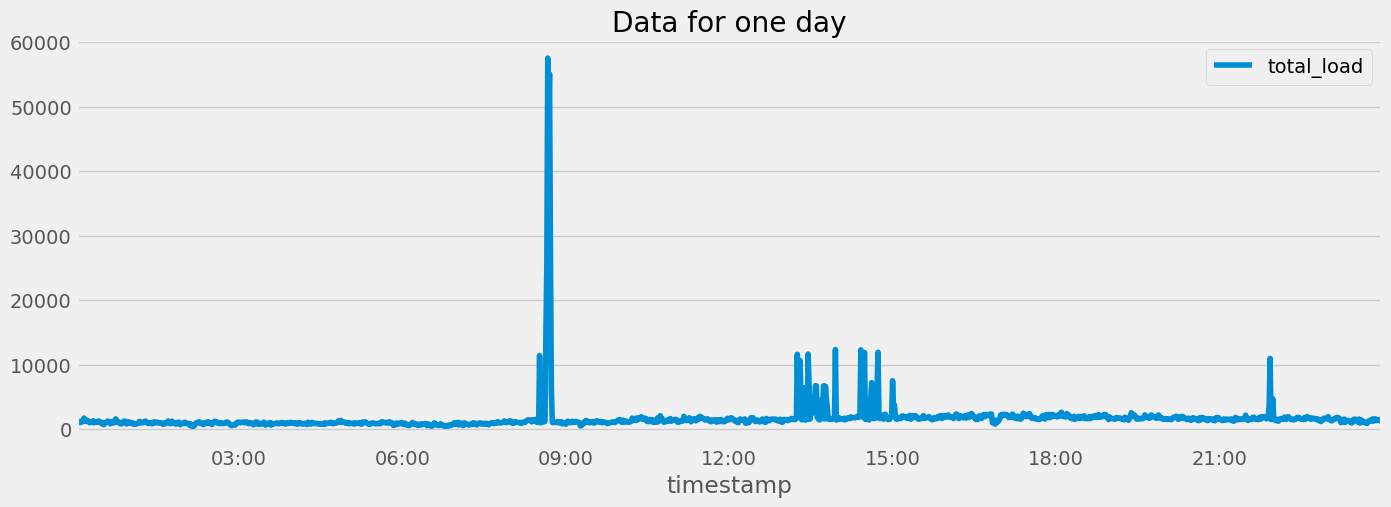

In [175]:
historical_df.loc[(historical_df.index > '1998-05-12 00:00:00') & (historical_df.index < '1998-05-13 00:00:00')] \
    .plot(figsize=(15, 5), title='Data for one day')
plt.show()

In [176]:

def create_features_xgboost(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
   #df['minute'] = df.index.minute NOT NECESSARY
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df

df = create_features_xgboost(hourly_sum)
df

,total_load,hour,dayofweek
timestamp,,,
1998-05-02 00:00:00,31969,0,5
1998-05-02 01:00:00,31132,1,5
1998-05-02 02:00:00,27349,2,5
1998-05-02 03:00:00,29052,3,5
1998-05-02 04:00:00,28462,4,5
...,...,...,...
1998-05-31 19:00:00,175295,19,6
1998-05-31 20:00:00,179101,20,6
1998-05-31 21:00:00,175539,21,6


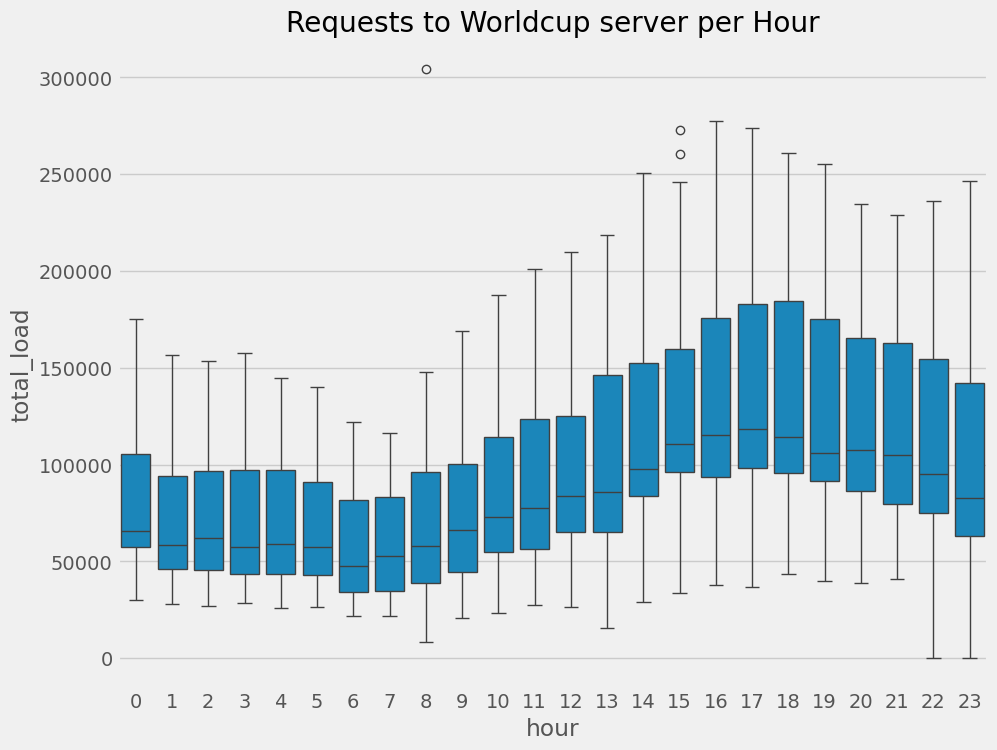

In [177]:
# Visualize

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='total_load')
ax.set_title('Requests to Worldcup server per Hour')
plt.show()

## Deleta outliers

Text(0.5, 1.0, 'Requests to Worldcup server per Hour (Without Outliers)')

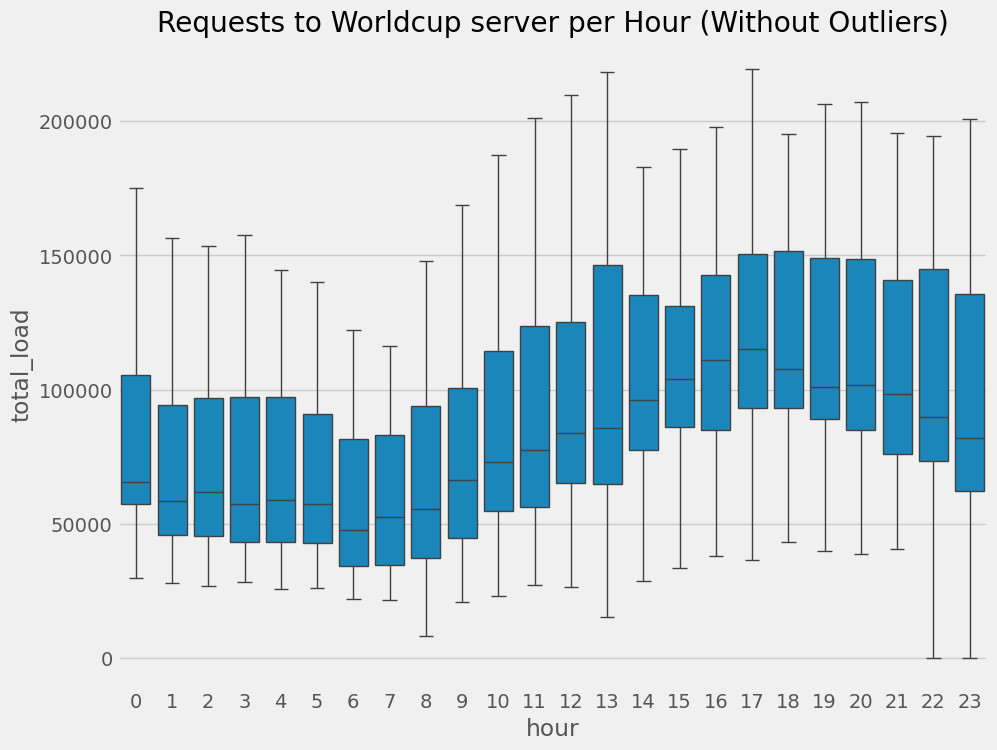

In [209]:
# Assuming df is your DataFrame containing the data

Q1 = df['total_load'].quantile(0.25)
Q3 = df['total_load'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['total_load'] >= lower_bound) & (df['total_load'] <= upper_bound)]

# Plot the boxplot without outliers
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_filtered, x='hour', y='total_load')
ax.set_title('Requests to Worldcup server per Hour (Without Outliers)')

In [179]:
train = create_features_xgboost(train)
test = create_features_xgboost(test)

FEATURES = ['hour', 'dayofweek']
TARGET = 'total_load'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [180]:
reg = xgb.XGBRegressor(n_estimators = 2000, early_stopping_rounds = 50,learning_rate=0.01,
        enable_categorical = True)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:49059.32528	validation_1-rmse:94809.02329


[100]	validation_0-rmse:38506.50484	validation_1-rmse:93653.19158
[144]	validation_0-rmse:37229.06124	validation_1-rmse:93757.48238


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature importances

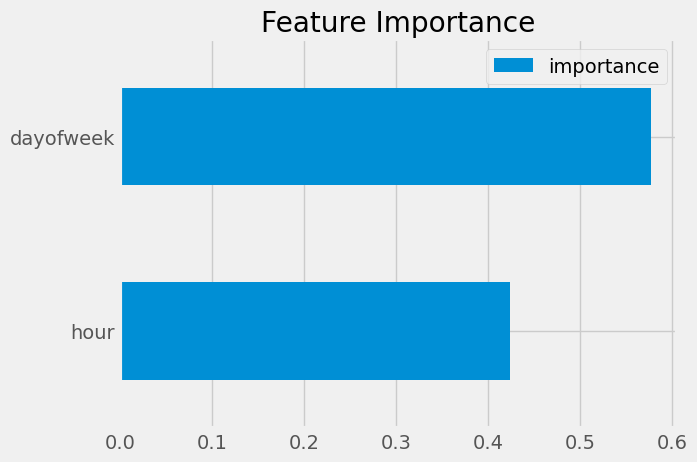

In [181]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

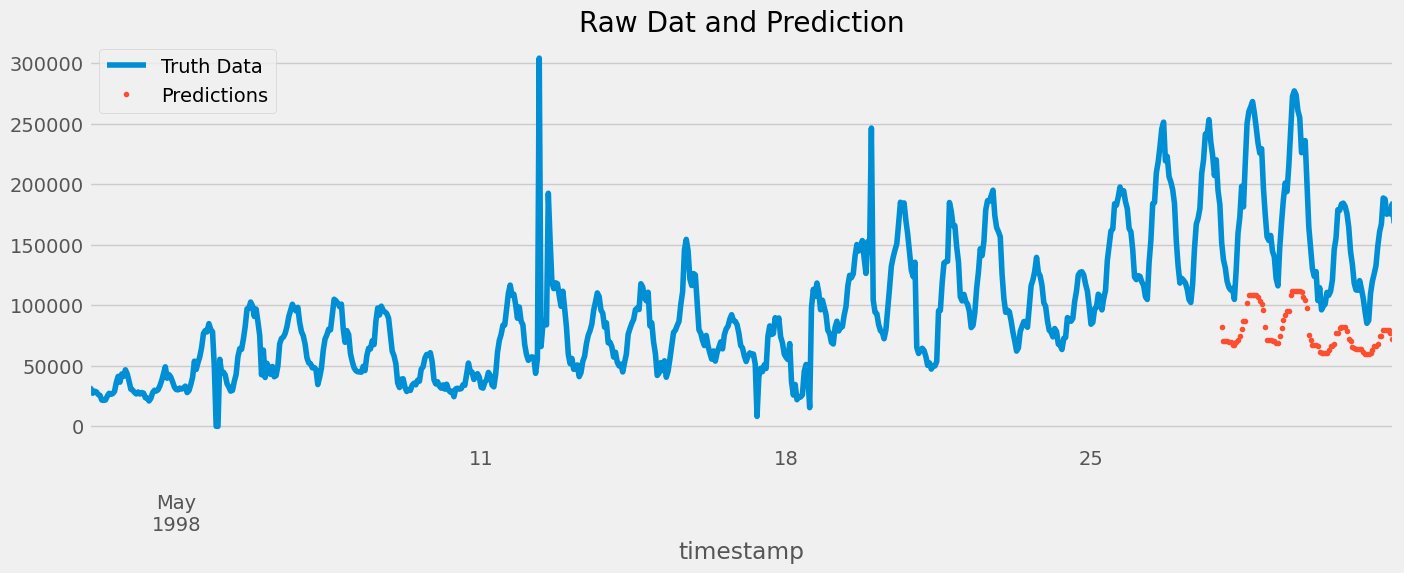

In [182]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['total_load']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


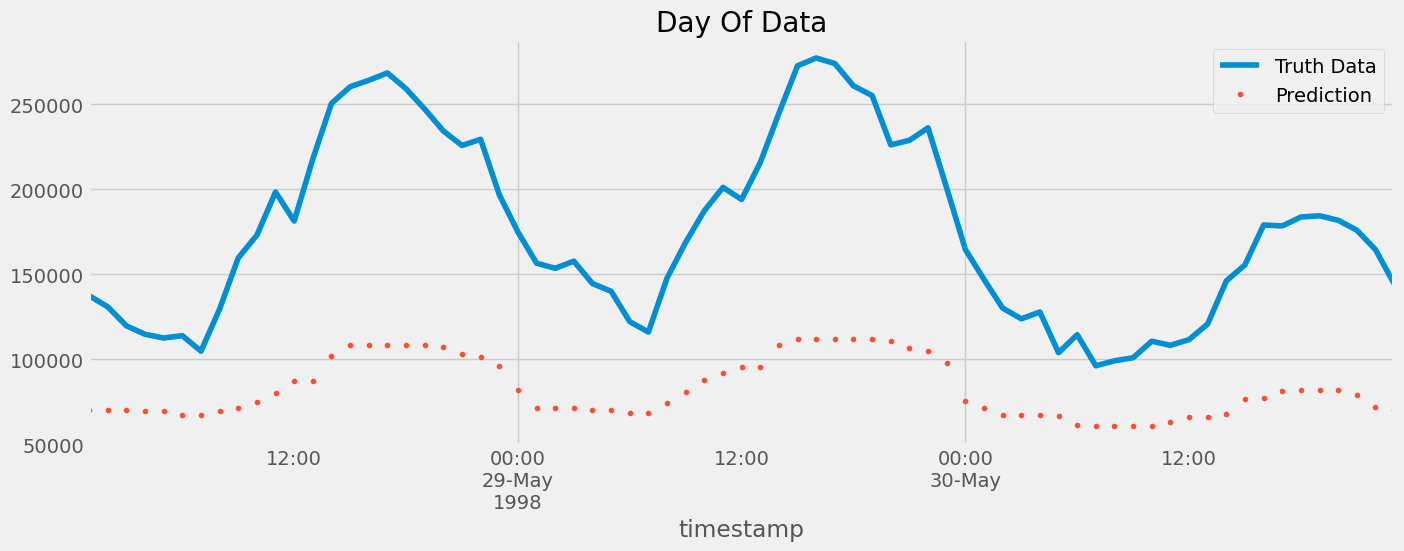

In [185]:
ax = df.loc[(df.index > '1998-05-28 00:00:00') & (df.index < '1998-05-31 00:00:00')]['total_load'] \
    .plot(figsize=(15, 5), title='Day Of Data')
df.loc[(df.index > '1998-05-28 00:00:00') & (df.index < '1998-05-31 00:00:00')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()


In [186]:
###För att kika vilka dagar som var sämst predictade

score = np.sqrt(mean_squared_error(test['total_load'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

RMSE Score on Test set: 93646.07


date
1998-05-29    107027.572266
1998-05-28     99672.231445
1998-05-31     69592.333984
1998-05-30     69490.893392
Name: error, dtype: float64

### Skapa framtida prediktion!

In [187]:
from datetime import timedelta
last_date = historical_df.index.max().replace(hour=0, minute=0, second=0)
next_five_days_dates = pd.date_range(start=last_date+timedelta(days=1), end=last_date +timedelta(days=16), freq='T')


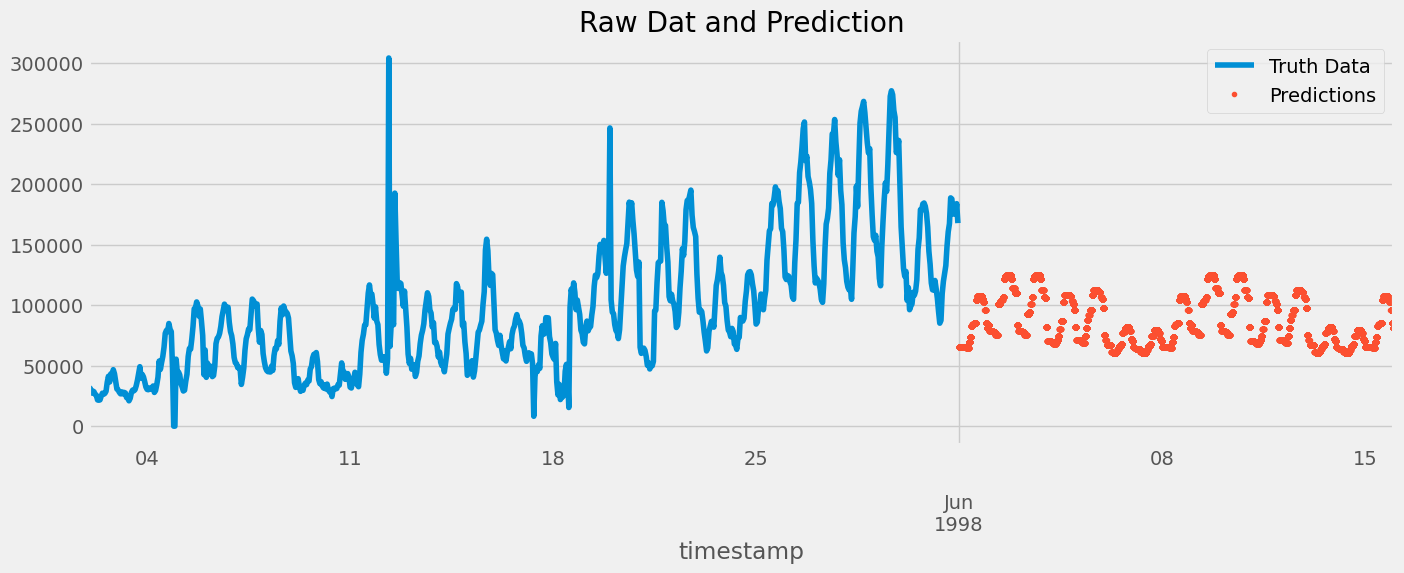

In [189]:
next_days_df = pd.DataFrame(next_five_days_dates, columns=["timestamp"])
next_days_df = next_days_df.set_index("timestamp")
next_day_test = create_features_xgboost(next_days_df)
next_days_df['prediction'] = reg.predict(next_day_test)
#df = df.merge(next_days_df[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['total_load']].plot(figsize=(15, 5))
next_days_df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

## Time series Cross Validation

In [190]:
from sklearn.model_selection import TimeSeriesSplit

In [191]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24, gap=1) #hour/dayofweek
df = df_filtered.sort_index()
df.tail()

,total_load,hour,dayofweek
timestamp,,,
1998-05-31 19:00:00,175295,19,6
1998-05-31 20:00:00,179101,20,6
1998-05-31 21:00:00,175539,21,6
1998-05-31 22:00:00,183921,22,6
1998-05-31 23:00:00,167838,23,6


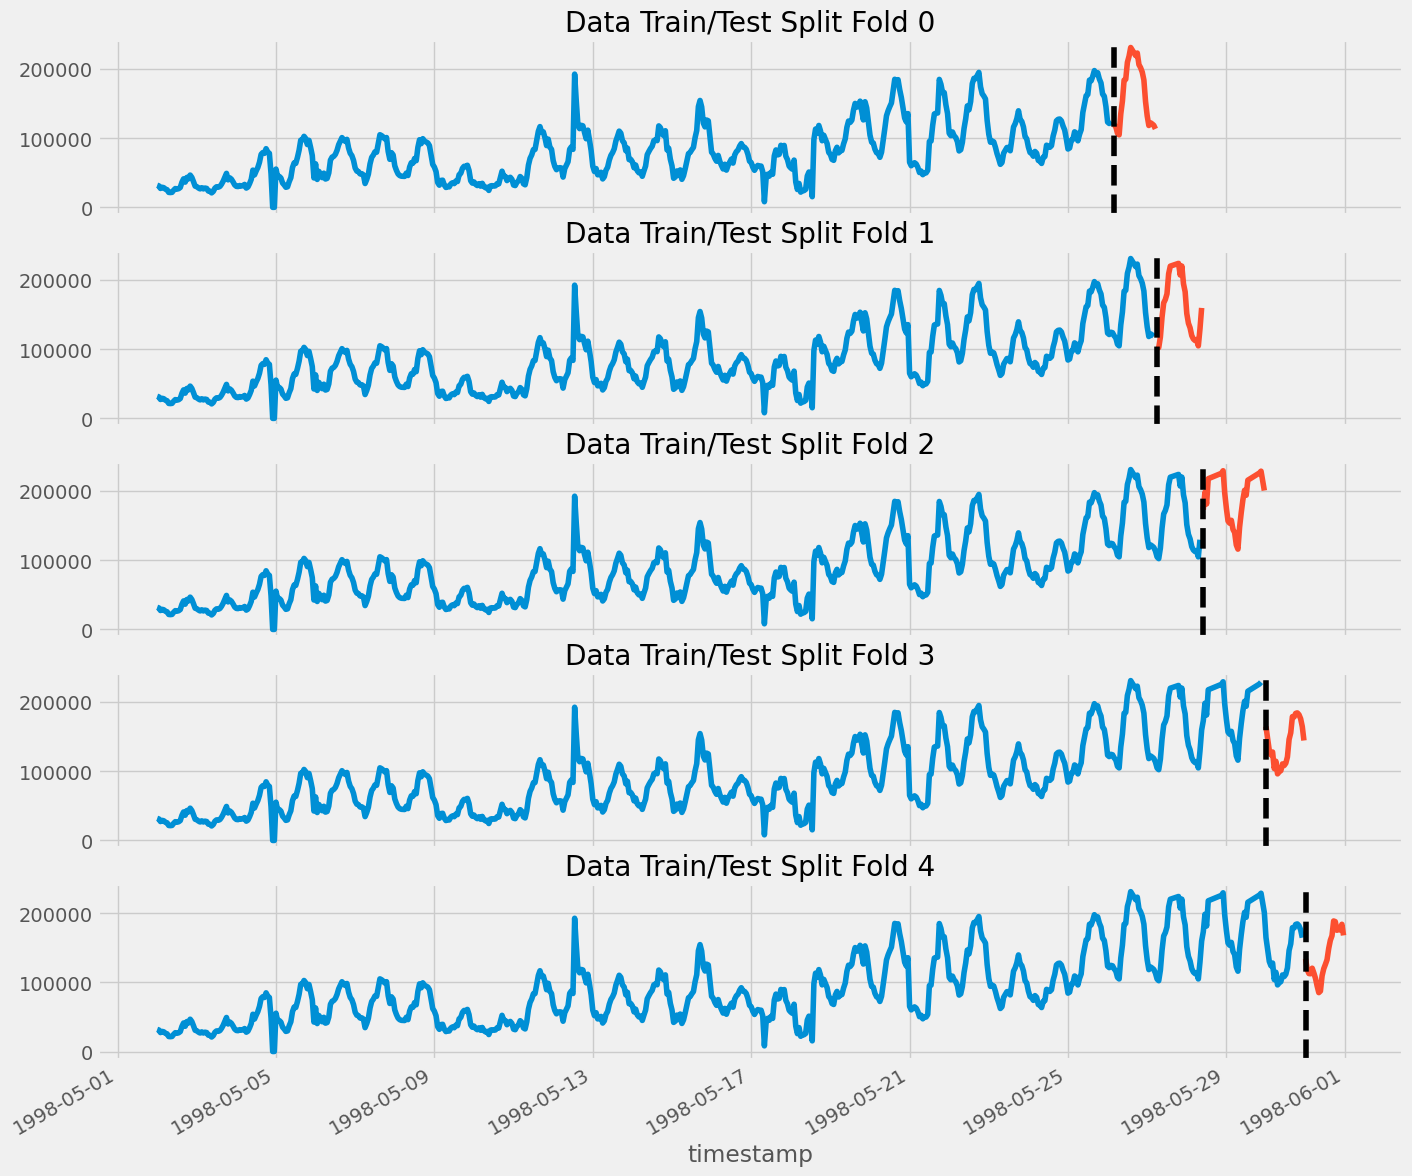

In [192]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['total_load'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['total_load'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Lag filters

Look back in to the past, use the target value for that many days in the past. What was the trarget(x) in the past?

In [193]:
def add_lags(df):
    target_map = df['total_load'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    return df
df = add_lags(df)
df.tail()

,total_load,hour,dayofweek,lag1,lag2,lag3,lag4
timestamp,,,,,,,
1998-05-31 19:00:00,175295,19,6,127748.0,84621.0,44813.0,39773.0
1998-05-31 20:00:00,179101,20,6,125085.0,89565.0,38727.0,42711.0
1998-05-31 21:00:00,175539,21,6,117607.0,74049.0,41945.0,40682.0
1998-05-31 22:00:00,183921,22,6,111806.0,68976.0,43480.0,36780.0
1998-05-31 23:00:00,167838,23,6,98877.0,59644.0,40514.0,32387.0


Train using the CV and the lag filters

In [239]:
tss = TimeSeriesSplit(n_splits=10, test_size=24, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features_xgboost(train)
    test = create_features_xgboost(test)

    FEATURES = ['hour', 'dayofweek',
                'lag1','lag2','lag3']
    TARGET = 'total_load'
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:71630.53228	validation_1-rmse:113949.18994


[100]	validation_0-rmse:30712.56552	validation_1-rmse:60991.97000
[200]	validation_0-rmse:16611.96100	validation_1-rmse:41964.83756
[300]	validation_0-rmse:12232.12164	validation_1-rmse:35250.81654
[400]	validation_0-rmse:10443.60774	validation_1-rmse:34027.28138


KeyboardInterrupt: 

In [195]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 30677.9507
Fold scores:[31831.14323326395, 21262.159523383827, 18664.051436924026, 22952.13422016236, 73298.96897372344, 49082.55003774908, 30761.18894733064, 28182.522680345824, 13335.217735286156, 17409.5702323988]


In [ ]:
mme = np.sqrt(mean_squared_error(y_true=targetdevice_test['total_load'],
                   y_pred=targetdevice_test_fcst['yhat']))

mse = mean_absolute_error(y_true=targetdevice_test['total_load'],
                   y_pred=targetdevice_test_fcst['yhat'])

msp = mean_absolute_percentage_error(y_true=targetdevice_test['total_load'],
                   y_pred=targetdevice_test_fcst['yhat'])

print(mme,mse,msp)

## Predict the future

In [196]:
# Retrain on all data
df = create_features_xgboost(df)

FEATURES = ['hour', 'dayofweek',
                'lag1','lag2','lag3']
TARGET = 'total_load'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=3000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:103055.71293


[100]	validation_0-rmse:42538.96809
[200]	validation_0-rmse:22230.72807
[300]	validation_0-rmse:15494.79898
[400]	validation_0-rmse:13564.40037
[500]	validation_0-rmse:12671.36452
[600]	validation_0-rmse:12133.25828
[700]	validation_0-rmse:11784.33549
[800]	validation_0-rmse:11513.74388
[900]	validation_0-rmse:11267.49655
[1000]	validation_0-rmse:11066.03134
[1100]	validation_0-rmse:10903.10121
[1200]	validation_0-rmse:10709.63398
[1300]	validation_0-rmse:10524.79242
[1400]	validation_0-rmse:10345.03689
[1500]	validation_0-rmse:10167.37322
[1600]	validation_0-rmse:10019.50563
[1700]	validation_0-rmse:9866.00555
[1800]	validation_0-rmse:9728.97450
[1900]	validation_0-rmse:9561.58426
[2000]	validation_0-rmse:9410.50744
[2100]	validation_0-rmse:9307.70957
[2200]	validation_0-rmse:9166.89682
[2300]	validation_0-rmse:9044.68788
[2400]	validation_0-rmse:8892.86038
[2500]	validation_0-rmse:8773.11234
[2600]	validation_0-rmse:8697.69079
[2700]	validation_0-rmse:8607.26296
[2800]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [197]:
df.index.max()
# Create future dataframe
future = pd.date_range('1998-05-31 23:00:00','1998-06-05 00:00:00', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features_xgboost(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()
future_w_features
df_and_future


,total_load,hour,dayofweek,lag1,lag2,lag3,lag4,isFuture
1998-05-02 00:00:00,31969.0,0,5,NaN,NaN,NaN,NaN,False
1998-05-02 01:00:00,31132.0,1,5,NaN,NaN,NaN,NaN,False
1998-05-02 02:00:00,27349.0,2,5,NaN,NaN,NaN,NaN,False
1998-05-02 03:00:00,29052.0,3,5,NaN,NaN,NaN,NaN,False
1998-05-02 04:00:00,28462.0,4,5,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...
1998-06-04 20:00:00,NaN,20,3,NaN,165674.0,110814.0,80775.0,True
1998-06-04 21:00:00,NaN,21,3,225793.0,165954.0,83006.0,69437.0,True
1998-06-04 22:00:00,NaN,22,3,229448.0,148252.0,85530.0,79106.0,True
1998-06-04 23:00:00,NaN,23,3,196894.0,135631.0,69637.0,75828.0,True


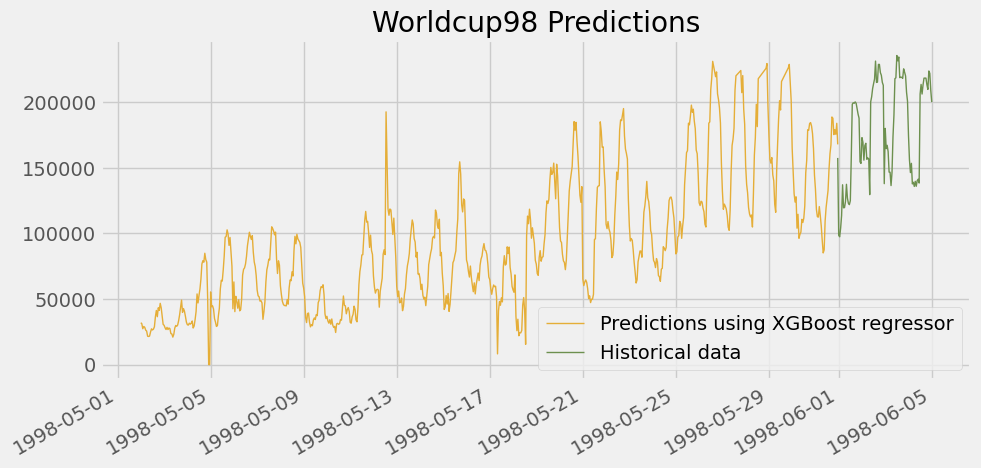

In [198]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])



df_and_future['total_load'].plot(figsize=(10, 5),
                               color=color_pal[2],
                               ms=1,
                               lw=1,)
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Worldcup98 Predictions')

plt.legend(['Predictions using XGBoost regressor','Historical data'])

plt.show()

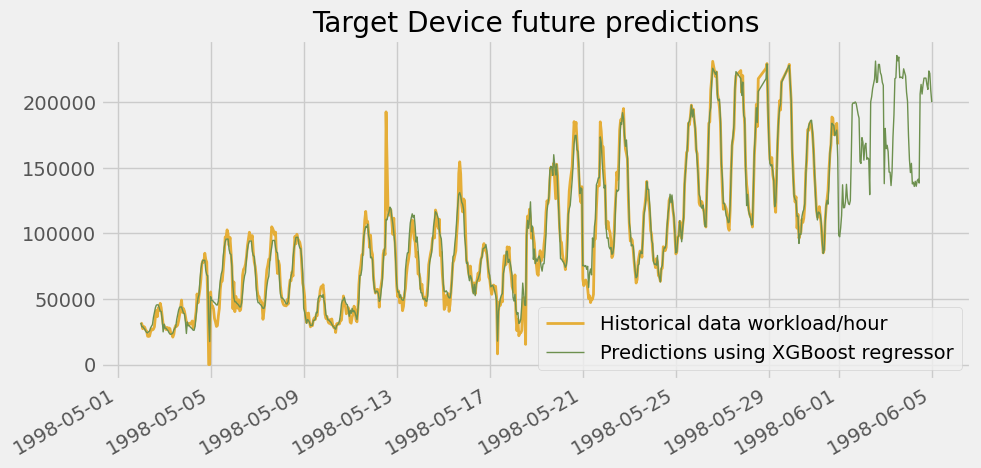

In [199]:
df_and_future['pred'] = reg.predict(df_and_future[FEATURES])


df_and_future['total_load'].plot(figsize=(10, 5),
                               color=color_pal[2],
                               ms=2,
                               lw=2,)
df_and_future['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Target Device future predictions')
plt.legend(['Historical data workload/hour ','Predictions using XGBoost regressor'])

plt.show()


# Prophet prediction algoritm

In [69]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

#Easier to undestand - gives th aarage percent off what our prediction is from the ground truth.
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [210]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    X = df[['hour','dayofweek','weekday',
           ]]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df_filtered, label='total_load')
features_and_target = pd.concat([X, y], axis=1)
features_and_target

,hour,dayofweek,weekday,total_load
timestamp,,,,
1998-05-02 00:00:00,0,5,Saturday,31969
1998-05-02 01:00:00,1,5,Saturday,31132
1998-05-02 02:00:00,2,5,Saturday,27349
1998-05-02 03:00:00,3,5,Saturday,29052
1998-05-02 04:00:00,4,5,Saturday,28462
...,...,...,...,...
1998-05-31 19:00:00,19,6,Sunday,175295
1998-05-31 20:00:00,20,6,Sunday,179101
1998-05-31 21:00:00,21,6,Sunday,175539


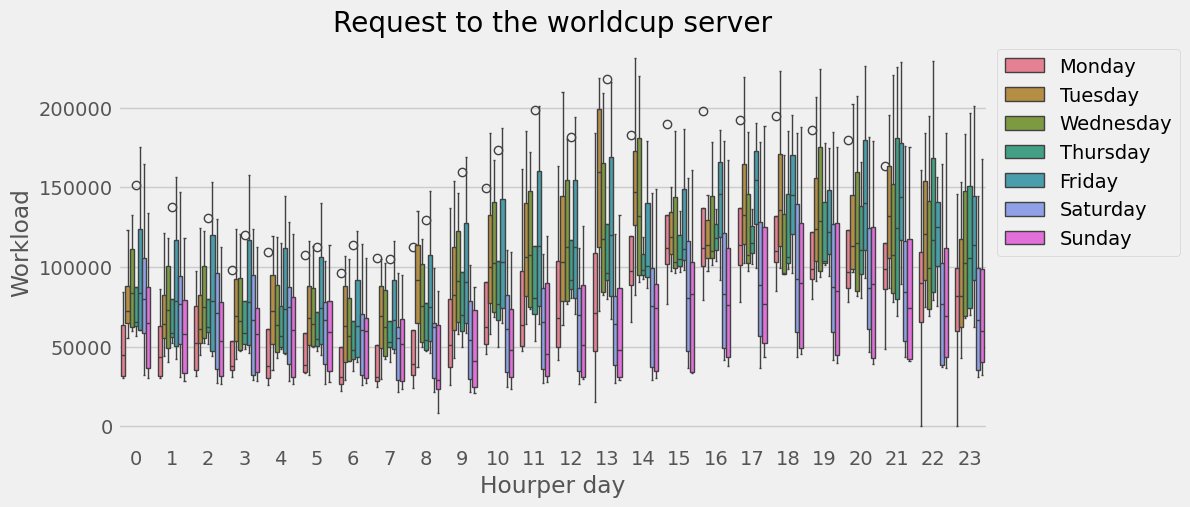

In [207]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='hour',
            y='total_load',
            hue='weekday',
            ax=ax,
            linewidth=1)
ax.set_title('Request to the worldcup server')
ax.set_xlabel('Hourper day')
ax.set_ylabel('Workload')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### Train/Test split

Text(0.5, 1.0, 'Requests to Worldcup server per Hour (Without Outliers)')

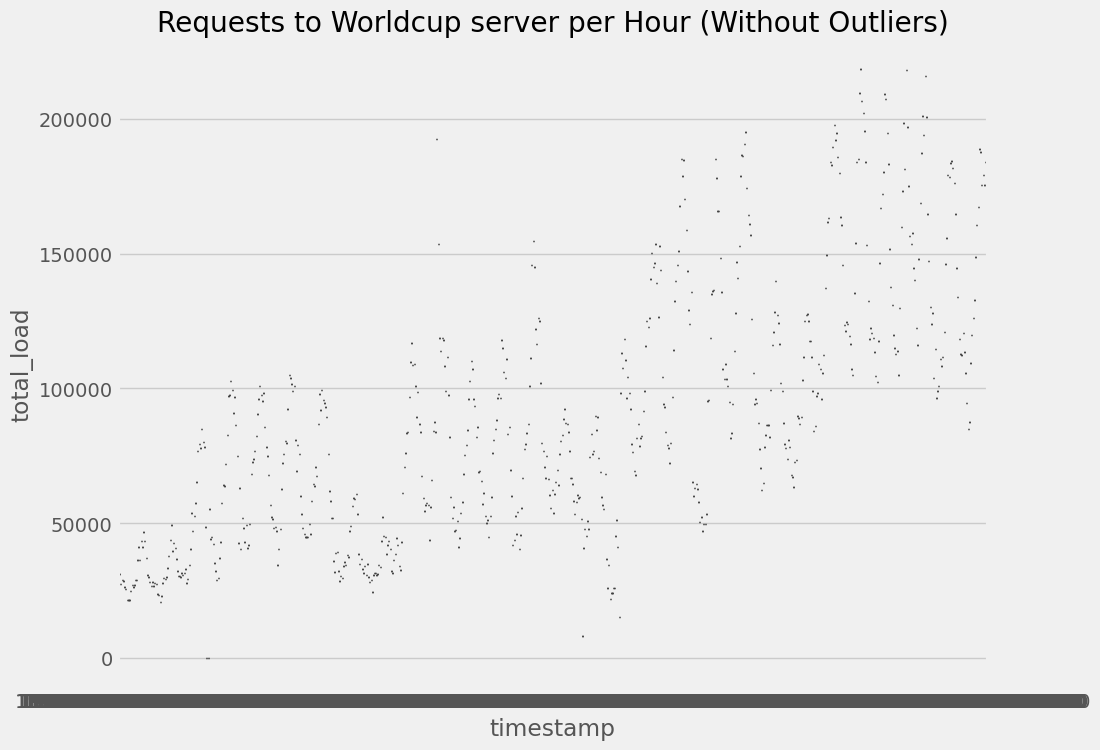

In [215]:

Q1 = features_and_target['total_load'].quantile(0.25)
Q3 = features_and_target['total_load'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered_prophet = features_and_target[(features_and_target['total_load'] >= lower_bound) & (features_and_target['total_load'] <= upper_bound)]

# Plot the boxplot without outliers
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_filtered_prophet, x='timestamp', y='total_load')
ax.set_title('Requests to Worldcup server per Hour (Without Outliers)')

In [229]:
def add_lags_prophet(df):
    target_map = df['total_load'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    return df
df_filtered_prophet = add_lags_prophet(df_filtered_prophet)
df_filtered_prophet

,hour,dayofweek,weekday,total_load,lag1,lag2,lag3
timestamp,,,,,,,
1998-05-02 00:00:00,0,5,Saturday,31969,NaN,NaN,NaN
1998-05-02 01:00:00,1,5,Saturday,31132,NaN,NaN,NaN
1998-05-02 02:00:00,2,5,Saturday,27349,NaN,NaN,NaN
1998-05-02 03:00:00,3,5,Saturday,29052,NaN,NaN,NaN
1998-05-02 04:00:00,4,5,Saturday,28462,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1998-05-31 19:00:00,19,6,Sunday,175295,127748.0,84621.0,44813.0
1998-05-31 20:00:00,20,6,Sunday,179101,125085.0,89565.0,38727.0
1998-05-31 21:00:00,21,6,Sunday,175539,117607.0,74049.0,41945.0


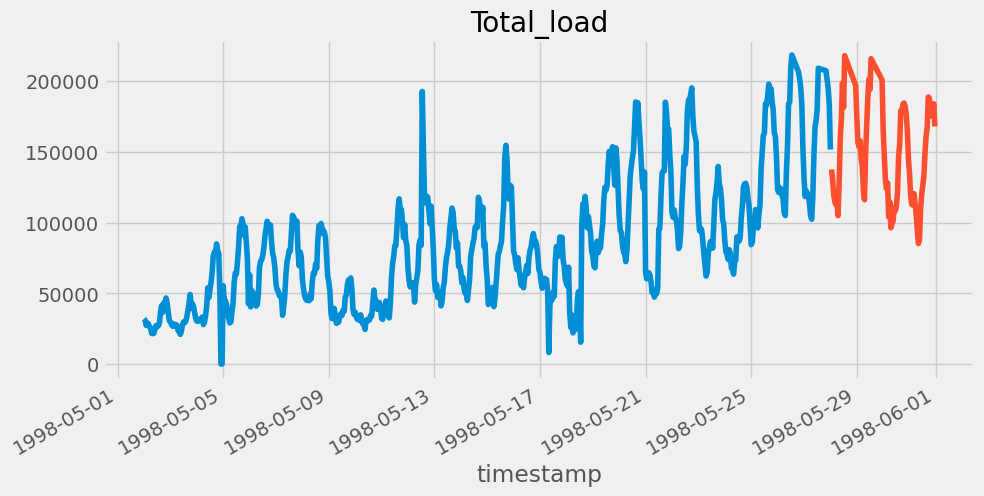

In [230]:
# Assuming targetdevice_train and targetdevice_test are DataFrames
split_date = '28-May-1998'
targetdevice_train = df_filtered_prophet.loc[df_filtered_prophet.index <= split_date].copy()
targetdevice_test = df_filtered_prophet.loc[df_filtered_prophet.index > split_date].copy()

# Plot train and test so you can see where we have split
merged_df = targetdevice_test.rename(columns={'total_load': 'TEST SET'}) \
    .join(targetdevice_train.rename(columns={'total_load': 'TRAINING SET'}),
          how='outer', lsuffix='_test', rsuffix='_train')  # Specify suffixes
merged_df["TRAINING SET"].plot(figsize=(10, 5), title='Total_load', ms=1)
merged_df["TEST SET"].plot(figsize=(10, 5), title='Total_load', ms=1)
plt.show()

## Simple Prophet Model
 Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
 Datetime column named: ds
 target : y

In [231]:
# Format data for prophet model using ds and y
targetdevice_train_prophet = targetdevice_train.reset_index() \
    .rename(columns={'timestamp':'ds',
                     'total_load':'y'})
targetdevice_train_prophet

,ds,hour,dayofweek,weekday,y,lag1,lag2,lag3
0,1998-05-02 00:00:00,0,5,Saturday,31969,NaN,NaN,NaN
1,1998-05-02 01:00:00,1,5,Saturday,31132,NaN,NaN,NaN
2,1998-05-02 02:00:00,2,5,Saturday,27349,NaN,NaN,NaN
3,1998-05-02 03:00:00,3,5,Saturday,29052,NaN,NaN,NaN
4,1998-05-02 04:00:00,4,5,Saturday,28462,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
606,1998-05-27 13:00:00,13,2,Wednesday,209070,150910.0,84672.0,82403.0
607,1998-05-27 20:00:00,20,2,Wednesday,207295,143601.0,81920.0,85865.0
608,1998-05-27 22:00:00,22,2,Wednesday,194658,123710.0,69024.0,74778.0
609,1998-05-27 23:00:00,23,2,Wednesday,183122,135627.0,69449.0,67932.0


### Create model

In [232]:

model = Prophet()
model.fit(targetdevice_train_prophet)

15:04:11 - cmdstanpy - INFO - Chain [1] start processing
15:04:11 - cmdstanpy - INFO - Chain [1] done processing


In [233]:
# Predict on test set with model
targetdevice_test_prophet = targetdevice_test.reset_index() \
    .rename(columns={'timestamp':'ds',
                     'total_load':'y'})
targetdevice_test_fcst = model.predict(targetdevice_test_prophet)
targetdevice_test_fcst.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1998-05-28 01:00:00,154851.735202,118994.960229,161143.047311,154851.735202,154851.735202,-15464.407364,-15464.407364,-15464.407364,-19469.051885,-19469.051885,-19469.051885,4004.644521,4004.644521,4004.644521,0.0,0.0,0.0,139387.327838
1,1998-05-28 02:00:00,155153.622590,115125.859796,160853.860323,155153.622590,155153.622590,-17418.513693,-17418.513693,-17418.513693,-21040.542710,-21040.542710,-21040.542710,3622.029017,3622.029017,3622.029017,0.0,0.0,0.0,137735.108896
2,1998-05-28 03:00:00,155455.509977,116917.598706,159997.642266,155455.509977,155455.509977,-17207.520409,-17207.520409,-17207.520409,-20509.350834,-20509.350834,-20509.350834,3301.830425,3301.830425,3301.830425,0.0,0.0,0.0,138247.989569
3,1998-05-28 04:00:00,155757.397365,113392.355785,159597.517598,155757.397365,155757.397365,-18552.486054,-18552.486054,-18552.486054,-21599.529023,-21599.529023,-21599.529023,3047.042969,3047.042969,3047.042969,0.0,0.0,0.0,137204.911311
4,1998-05-28 05:00:00,156059.284753,112264.438752,155698.652023,156054.976957,156059.555299,-22651.582154,-22651.582154,-22651.582154,-25511.623125,-25511.623125,-25511.623125,2860.040971,2860.040971,2860.040971,0.0,0.0,0.0,133407.702600


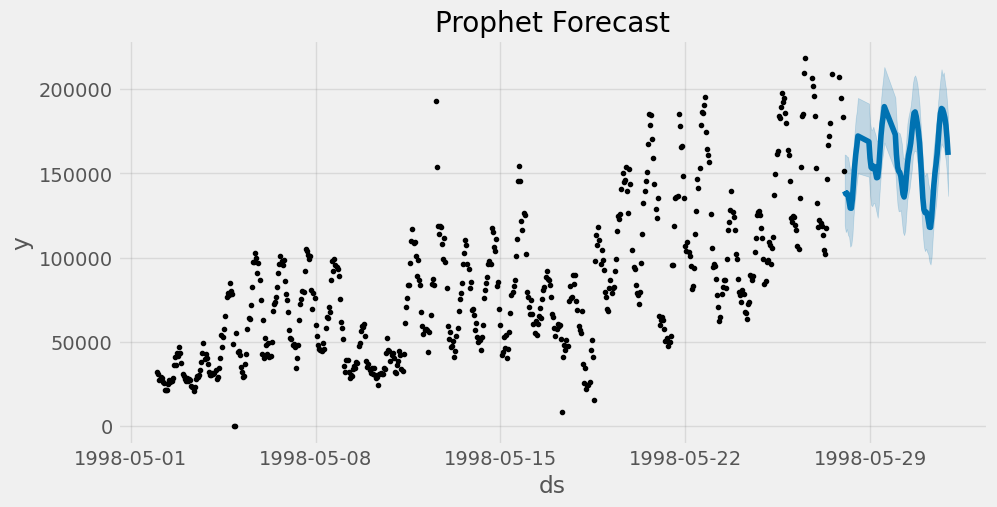

In [234]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(targetdevice_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

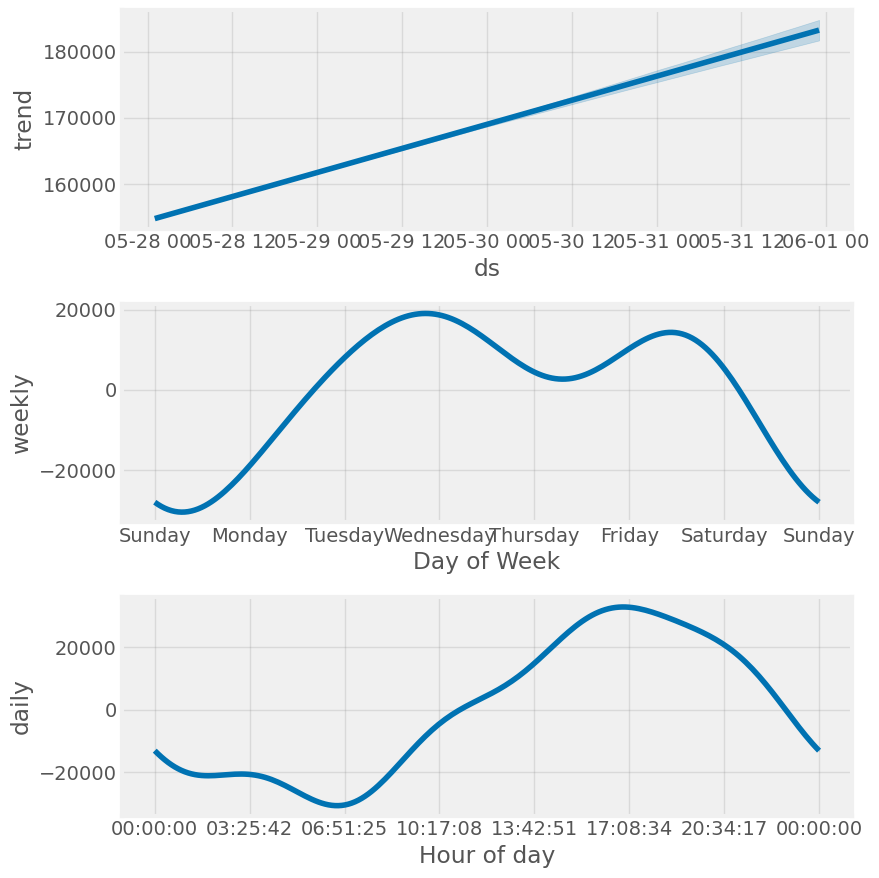

In [235]:
fig = model.plot_components(targetdevice_test_fcst)
plt.show()


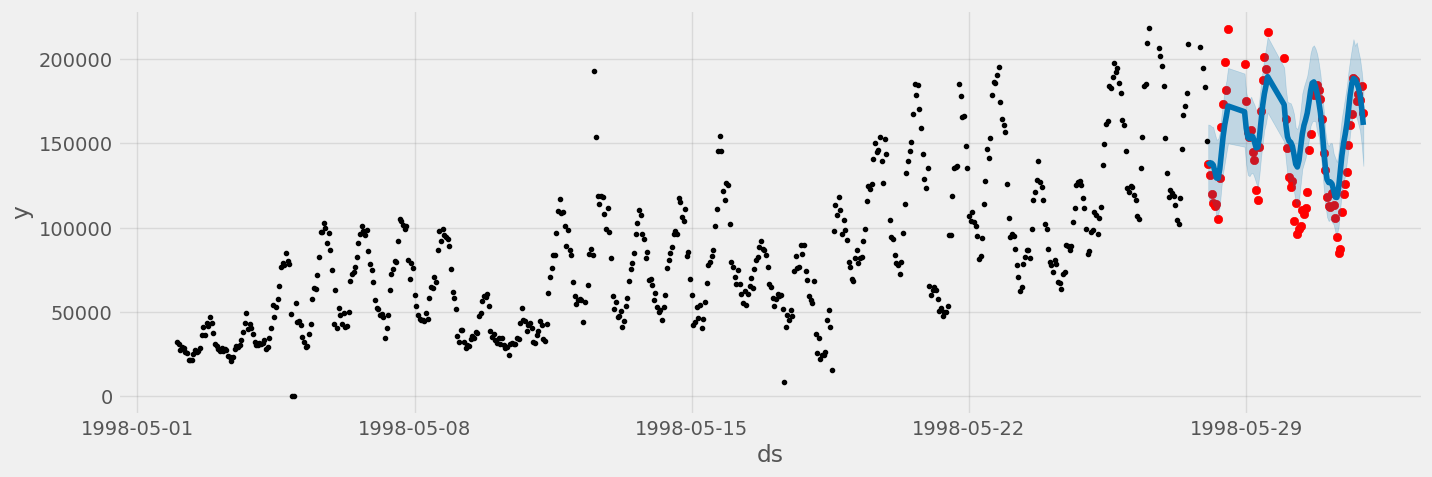

In [236]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(targetdevice_test.index, targetdevice_test['total_load'], color='r')
fig = model.plot(targetdevice_test_fcst, ax=ax)



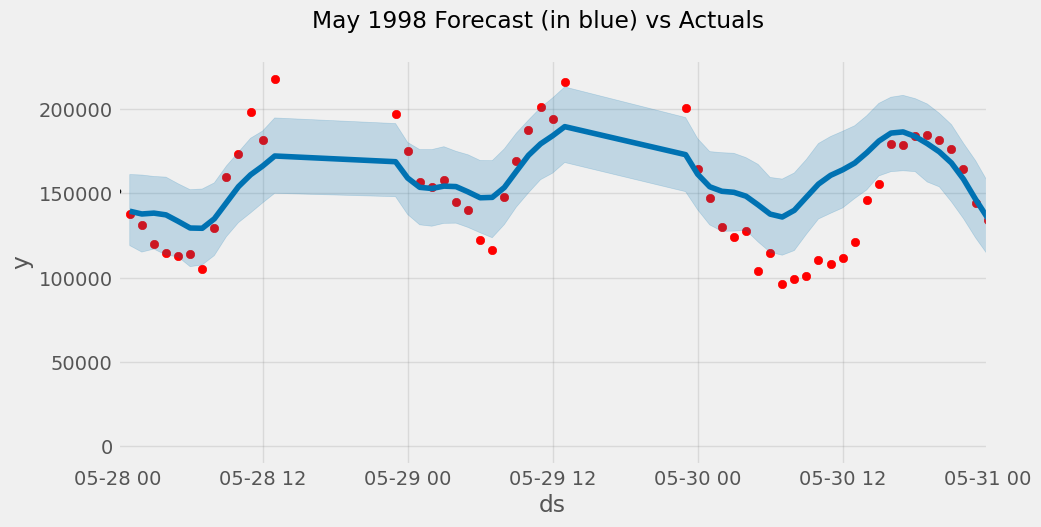

In [237]:
#targetdevice_test.index = pd.to_datetime(targetdevice_test.index)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(targetdevice_test.index, targetdevice_test['total_load'], color='r')
fig = model.plot(targetdevice_test_fcst, ax=ax)
lower_date = pd.to_datetime('1998-05-28')
upper_date = pd.to_datetime('1998-05-31')

ax.set_xbound(lower=lower_date, upper=upper_date)
plot = plt.suptitle('May 1998 Forecast (in blue) vs Actuals')

## Evaluation of the model 

In [238]:
mme = np.sqrt(mean_squared_error(y_true=targetdevice_test['total_load'],
                   y_pred=targetdevice_test_fcst['yhat']))

mse = mean_absolute_error(y_true=targetdevice_test['total_load'],
                   y_pred=targetdevice_test_fcst['yhat'])

msp = mean_absolute_percentage_error(y_true=targetdevice_test['total_load'],
                   y_pred=targetdevice_test_fcst['yhat'])

print(mme,mse,msp)

23433.519496023335 18692.444581139353 14.762212198533408


# Här kommer kod sen innan! Allt ovanför följer youtube tutorials

In [200]:
#Small effort do delete outliers
# calculate summary statistics
data_mean, data_std = mean(historical_df["total_load"]), std(historical_df["total_load"])
cut_off = data_std * 1 #Räknas som outliers om de är mer än 2 standard deviations från medelvärdet. 
lower, upper = data_mean - cut_off, data_mean + cut_off
print(lower,upper)
print(data_mean)

outliers = [x for x in historical_df["total_load"] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
...
outliers_removed = [x for x in historical_df["total_load"] if x > lower and x < upper]
print(len(outliers_removed))
historical_df_outliers_removed = historical_df[(historical_df["total_load"] > lower) & (historical_df["total_load"] < upper)]


179.79130785156258 1930.7323596847773
1055.26183376817
Identified outliers: 1017
20447


In [248]:
X = historical_df['timestamp'].astype(int).values.reshape(-1, 1)
y = historical_df['total_load'].values.reshape(-1, 1)
print(X,y)

[[894067200000000000]
 [894067260000000000]
 [894067320000000000]
 ...
 [895363020000000000]
 [895363080000000000]
 [895363140000000000]] [[ 352]
 [ 373]
 [ 401]
 ...
 [ 957]
 [1252]
 [ 987]]


In [85]:
##Scale the data. This part doesnt work as expected.

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
print(X,y)

[[-1.73557606]
 [-1.73535727]
 [-1.73513848]
 ...
 [ 1.72934782]
 [ 1.7295666 ]
 [ 1.72978539]] [[-1.27776128]
 [-1.23208847]
 [-1.17119138]
 ...
 [ 0.89713476]
 [ 0.75794141]
 [ 0.29468856]]


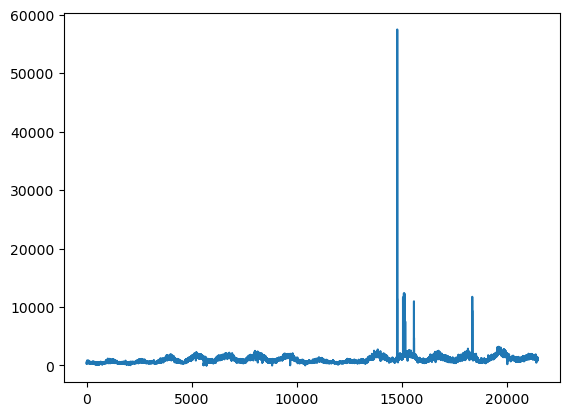

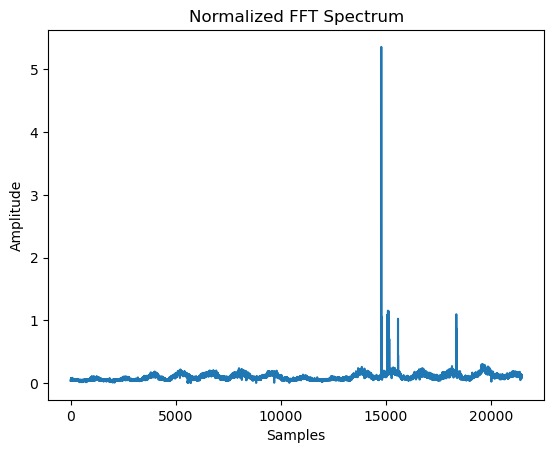

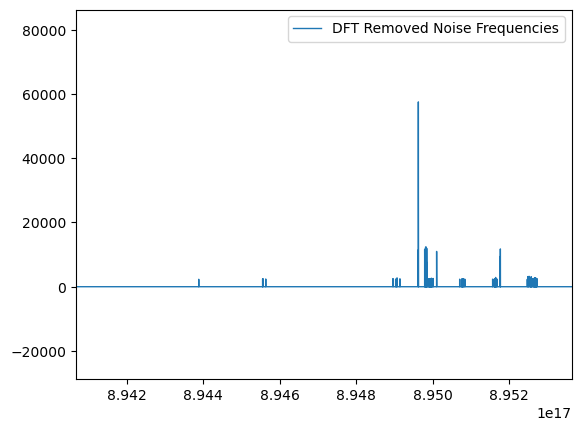

In [250]:
##Fourier aproximation FUNKAR EJ
# Apply the FFT on the signal
fourier = fft(y)

# Plot the result (the spectrum |Xk|)
plt.plot(np.abs(fourier))
plt.show()

N = len(y)
normalize = N/2

# Plot the normalized FFT (|Xk|)/(N/2)
plt.plot(np.abs(fourier)/normalize)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Normalized FFT Spectrum')
plt.show()

yf_abs      = np.abs(y) 
indices     = yf_abs>2300   # filter out those value under 300
yfClean    = indices * y # noise frequency will be set to 0
plt.plot(X,np.abs(yfClean),linewidth=1,label="DFT Removed Noise Frequencies")
plt.margins(x=0, y=0.5)
plt.legend()
plt.show()


In [223]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=(0.2/0.9), random_state=42) #Taget från intelligenta

In [204]:
# Model Evaluation
##Linear regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 151212.3521888552


In [32]:
#Support vector machines
# Train SVR model with polynomial kernel
poly_svr = make_pipeline(StandardScaler(), SVR(kernel='poly', degree=5, C=100, gamma="auto", epsilon=0.1, coef0=1))  # Adjust degree as needed
poly_svr.fit(X_train, y_train)
# Predict workload
y_pred = poly_svr.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 132627.36284775936


In [67]:

# Initialize variables to store best degree and corresponding MSE
best_degree = None
best_mse = float('inf')  # Initialize with a large value

# Try different degrees
for degree in range(1, 6):  # Try degrees 1 to 5
    # Train SVR model with polynomial kernel
    poly_svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', degree=degree))
    poly_svr.fit(X_train, y_train)

    # Predict workload on validation set
    y_pred = poly_svr.predict(X_val)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_val, y_pred)

    # Check if current degree gives lower MSE
    if mse < best_mse:
        best_mse = mse
        best_degree = degree

# Print the best degree and corresponding MSE
print("Best Degree:", best_degree)
print("Best MSE:", best_mse)

Best Degree: 1
Best MSE: 141895.00995225305


In [225]:
## Trying SVM with regression 
svr = SVR(C=1.0, epsilon=0.2).fit(X_train, y_train)
# Predict workload
y_pred = svr.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
score = svr.score(X,y)
print("R-squared:", score)


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 188461.48591859464


ValueError: X has 1 features, but SVR is expecting 100 features as input.

SVR()


In [139]:
## Decision Tree
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_tree)
print("Mean Squared Error:", mse)


Mean Squared Error: 22814.734977139124


In [140]:
## Random Forests
forest_model = RandomForestRegressor(max_depth= 10,min_samples_leaf = 1, min_samples_split = 10, n_estimators = 300)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_forest)
print("Mean Squared Error:", mse)

/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 22569.017421441826


In [ ]:
# parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],        # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required to be at a leaf node
}

forest_model = RandomForestRegressor()

grid_search = GridSearchCV(forest_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_forest_model = grid_search.best_estimator_
y_pred_forest = best_forest_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_forest)
print("Mean Squared Error:", mse)

print("Best Parameters:", grid_search.best_params_)

Mean Squared Error: 183.56072563159594
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


In [138]:

## Gradient Boosting
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)
y_pred_gbm = gbm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_gbm)
print("Mean Squared Error:", mse)

/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Mean Squared Error: 24500.401071219083


In [112]:
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train, y_train)
y_pred = knn_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
hyperparameters = {'n_neighbors': np.arange(1,30,1)}


Mean Squared Error: 16951.350847337446


In [219]:
last_date = historical_df_outliers_removed['timestamp'].max()
first_date = historical_df_outliers_removed['timestamp'].min()
next_day = last_date + pd.DateOffset(days=1)

#Prepare next day timestamps, starting from the beginning of the next day 
next_day_timestamps = pd.date_range(start=next_day.replace(hour=0, minute=0, second=0), end=next_day+ pd.DateOffset(days=1), freq='T')
all_days= pd.date_range(start=first_date.replace(hour=0, minute=0, second=0), end=next_day+ pd.DateOffset(days=1), freq='T')
print(next_day_timestamps)
print(all_days)

DatetimeIndex(['1998-05-17 00:00:00', '1998-05-17 00:01:00',
               '1998-05-17 00:02:00', '1998-05-17 00:03:00',
               '1998-05-17 00:04:00', '1998-05-17 00:05:00',
               '1998-05-17 00:06:00', '1998-05-17 00:07:00',
               '1998-05-17 00:08:00', '1998-05-17 00:09:00',
               ...
               '1998-05-18 23:50:00', '1998-05-18 23:51:00',
               '1998-05-18 23:52:00', '1998-05-18 23:53:00',
               '1998-05-18 23:54:00', '1998-05-18 23:55:00',
               '1998-05-18 23:56:00', '1998-05-18 23:57:00',
               '1998-05-18 23:58:00', '1998-05-18 23:59:00'],
              dtype='datetime64[ns]', length=2880, freq='T')
DatetimeIndex(['1998-05-02 00:00:00', '1998-05-02 00:01:00',
               '1998-05-02 00:02:00', '1998-05-02 00:03:00',
               '1998-05-02 00:04:00', '1998-05-02 00:05:00',
               '1998-05-02 00:06:00', '1998-05-02 00:07:00',
               '1998-05-02 00:08:00', '1998-05-02 00:09:00',
    

In [220]:
next_day_predictions = model.predict(next_day_timestamps.astype(int).values.reshape(-1, 1))  # Use your model to predict workload for next_day_timestamps
all_day_predictions = svr.predict(all_days.astype(int).values.reshape(-1, 1))
print(all_day_predictions)


[ 473.70145474  473.72024949  473.73908263 ... 1036.21991117 1036.17872824
 1036.13754962]


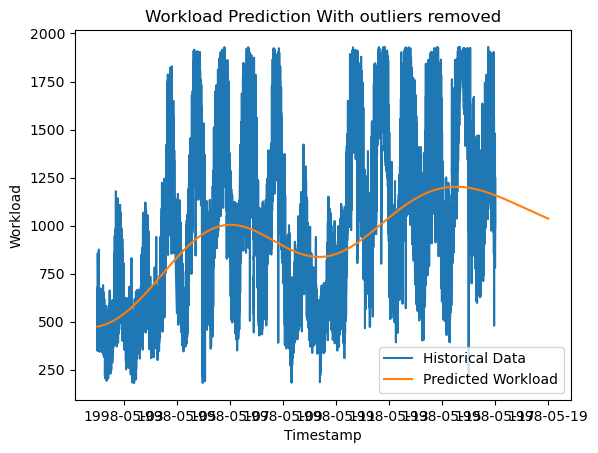

In [221]:
plt.plot(historical_df_outliers_removed['timestamp'], historical_df_outliers_removed['total_load'], label='Historical Data')

plt.plot(all_days, all_day_predictions, label='Predicted Workload')
plt.xlabel('Timestamp')
plt.ylabel('Workload')
plt.title('Workload Prediction With outliers removed')
plt.legend()
plt.show()

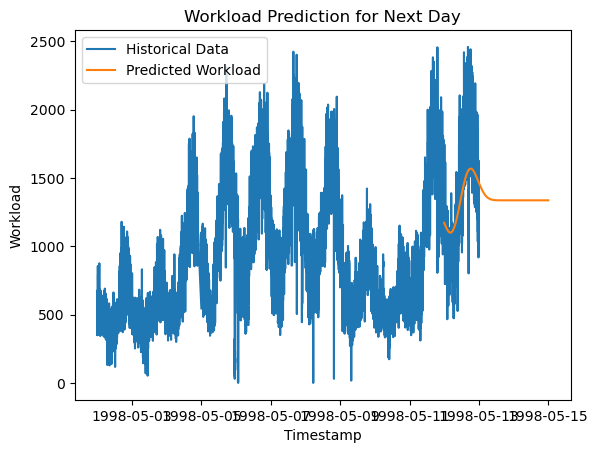

In [27]:
five_fays = first_date + pd.DateOffset(days=10)
last_five_days= pd.date_range(start=five_fays.replace(hour=0, minute=0, second=0), end=next_day+ pd.DateOffset(days=1), freq='T')
last_five_days_predictions = svr.predict(last_five_days.astype(int).values.reshape(-1, 1))

plt.plot(historical_df['timestamp'], historical_df['total_load'], label='Historical Data')

plt.plot(last_five_days, last_five_days_predictions, label='Predicted Workload')
plt.xlabel('Timestamp')
plt.ylabel('Workload')
plt.title('Workload Prediction for Next Day')
plt.legend()
plt.show()